
# Test:  Does the code agree with the Carenza and Marsh's plots?

-------------------------------

Here we want to test the code the code we developed (see the correspective notebook) in a priori way by choosing the gamma value and correcting the mass of the axion from this one. 

By setting $\gamma = 0.3$ and $1.5$, we can also test the plots Carenza and Marsh's paper https://arxiv.org/pdf/2302.02700. This is a good check to understand if the solver works. 

Note that for such big values of $\gamma$, the LZ approximation $P = 2\pi \gamma$ does not hold anymore. We write the code here in order that  

Check the main notebooks to understand the theory. 


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
import math


#OdeintW - wrapper to solve ODE with complex terms.
import odeintw 
from odeintw import odeintw


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D

In [2]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [29]:
#Setting the interval of integration, in units of Delta_{ag}Mpc, meaning working in \tilde{z}

zmin  = -5
zmax  = 5
z_num = 1000001
z_thr = np.linspace(zmin, zmax, z_num) 
z_res =  z_clust =  z_thr[500000] 
z_0 = z_thr[550000] #Just a pivotal scale

In [30]:
# To obtain a certain a priori choosen gamma, we need to set the quantities properly. We chose to do so by changing m_a: 

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

g_agg = 1e-10 * (GeV)**-1 
nu    = 145 * 10**9 * Hz 
omega = 2.*np.pi*nu 

def B_T(z):
    """
    Transverse magnetic field
    """
    return  1e-6 * Gauss  #in \mu G 

def Delta_ag(z):
    """
    Axion-photon coupling term
    Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
    """
    return g_agg/2 * B_T(z)

gamma_value = 0.0033 #0.33 #1.5   #CHOOSE HERE THE VALUE OF GAMMA

m_a   = np.sqrt(2* (gamma_value)**-1* omega * z_0  * Delta_ag(z_thr)) #Here is the setting to obtain m_a, given a value of gamma


def Delta_a(z):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 


def n_e(z):
    """
    Numerical density of electrons
    given by the halo model
    """
    return   (m_a**2 * mass_electron/(ElementaryCharge)**2 )  * (1+z/(z_0))  


def m2_g(z):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_e(z) #in eV units 


def Delta_parallel(z):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z) /(2* omega)


In [31]:
#Computing the derivative of Delta_parallel and the factor gamma  Delta_ag(\tilde{z})/|dDelta_ag(\tilde z) / d\tilde{z}|

dDelta_parallel = np.abs(np.gradient(Delta_parallel(z_thr), z_thr)) 

gamma_factor = (Delta_ag(z_thr))/(dDelta_parallel)
gamma_factor

array([0.0033, 0.0033, 0.0033, ..., 0.0033, 0.0033, 0.0033])

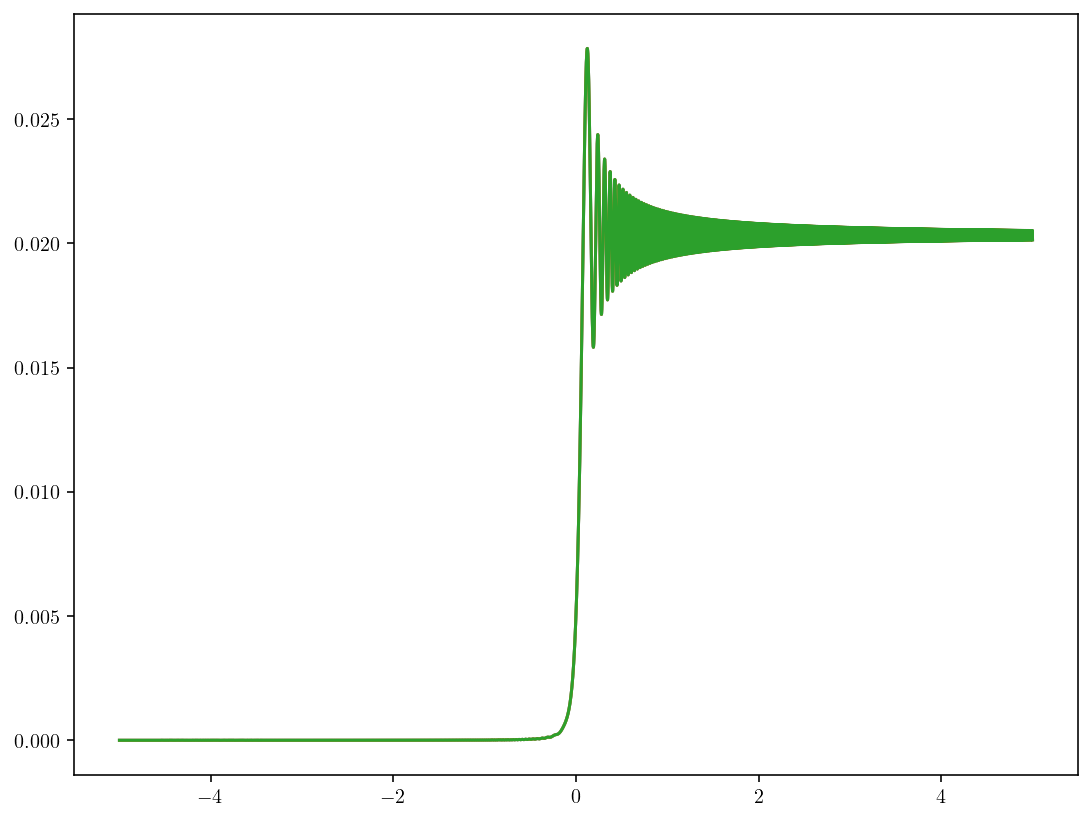

In [32]:
########################################
# Solving the differential equation in the three working ways listed above
########################################

#Defining the solvers:

#Working case 1)
def master_eq_LZ_1(z,S): #Note: in the case you want to solve with solve_ivp, use (z,S) instead of (S,z)
    """ Master equation """
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j * (Delta_parallel(z) - Delta_a(z))/(Delta_ag(z)) * f  - ax]
    return np.array(dSdz, dtype=np.complex128)

#Working case 2) 
def master_eq_LZ_2(z,S):
    """ Master equation written in gamma """
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j/gamma_factor[0] * z * f  - ax]
    return np.array(dSdz, dtype=np.complex128)

#Working case 3) (Carenza and Marsh equation)
def master_eq_LZ_3(z,S):
    """ Carenza and Marsh equation """
    S = np.asarray(S, dtype=np.complex128) 
    ax, f = S
    n = 1j * gamma_factor[0] #* gamma_factor[0]
    dSdz = [f, -1*(1+1/(2*n) - z**2/(2*n)**2 )*ax ]
    return np.array(dSdz, dtype=np.complex128)


#Initial values
z_init = z_thr[0]
ic_LZ = np.array([ 0, -1j ], dtype=np.complex128)


# Solving the ODE (solve_ivp method commented)
sol_LZ_1 = solve_ivp(master_eq_LZ_1, (z_thr[0], z_thr[-1]), ic_LZ, method='RK45', t_eval=z_thr, rtol=1e-8, atol=1e-10) #odeintw(master_eq_LZ_1, ic_LZ, z_thr) 

sol_LZ_2 = solve_ivp(master_eq_LZ_2, (z_thr[0], z_thr[-1]), ic_LZ, method='RK45', t_eval=z_thr, rtol=1e-8, atol=1e-10) #odeintw(master_eq_LZ_2, ic_LZ, z_thr) 

sol_LZ_3 = solve_ivp(master_eq_LZ_3, (z_thr[0], z_thr[-1]), ic_LZ, method='RK45', t_eval=z_thr, rtol=1e-8, atol=1e-10) #odeintw(master_eq_LZ_3, ic_LZ, z_thr)


#Squaring to obtain the probability
p_LZ_1 = np.abs(sol_LZ_1.y[0])**2 #np.abs(sol_LZ_1[:,0])**2  
p_LZ_2 = np.abs(sol_LZ_2.y[0])**2 #np.abs(sol_LZ_2[:,0])**2  
p_LZ_3 = np.abs(sol_LZ_3.y[0])**2 #np.abs(sol_LZ_3[:,0])**2  


#Plotting the solution
plt.plot(z_thr, p_LZ_1)
plt.plot(z_thr, p_LZ_2)
plt.plot(z_thr, p_LZ_3)
#plt.plot(z_thr, 2*np.pi*gamma_factor)


In [33]:
#Oscillation lenght and resonance lenght

#Oscillation lenght

z_test = z_thr[915001]
losc = 2*np.pi/ ( (Delta_parallel(z_test) - Delta_a(z_test) )/(Delta_ag(z_test)) )
print('losc is', losc)


#Resonance lenght
R_lenght = np.sqrt( 2*np.pi*gamma_factor[500000])/Delta_ag(z_thr[500000])
R_lenght_tilde =  np.sqrt( 2*np.pi*gamma_factor[500000])
print('R_lenght is', R_lenght_tilde)

losc is 0.004996255795454138
R_lenght is 0.14399483155192574


(3.95001, 4.35001)

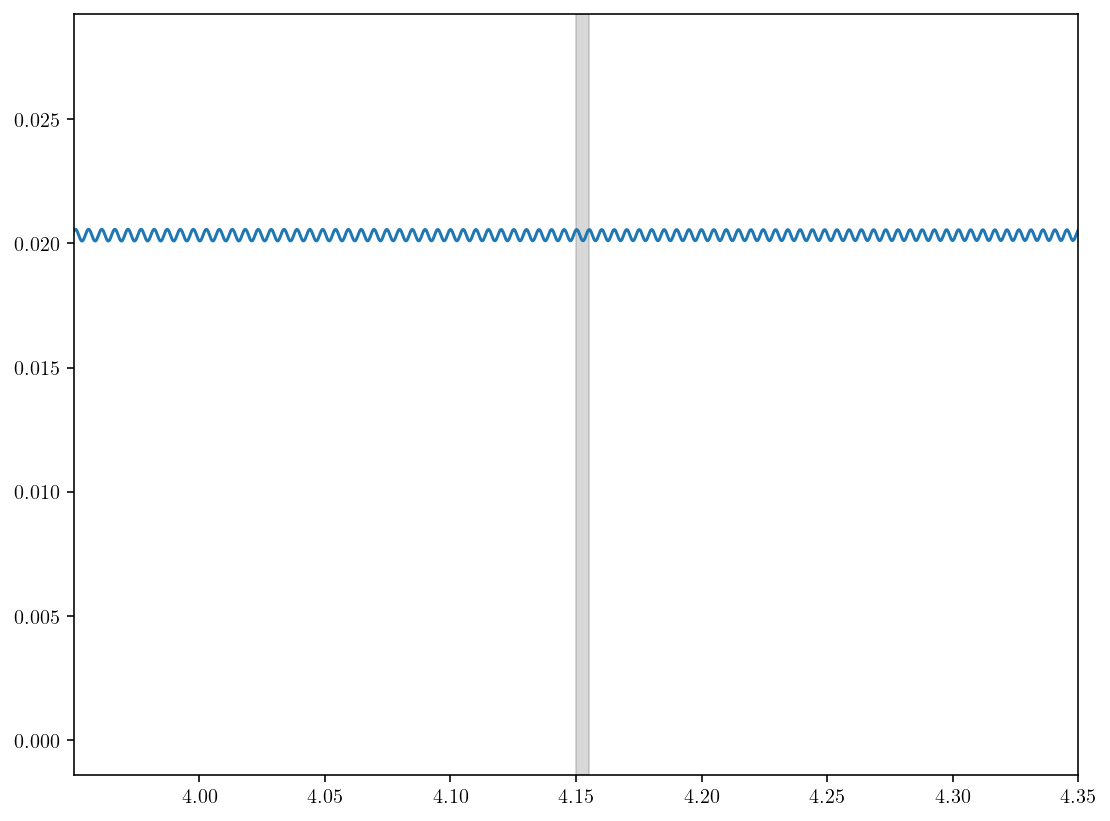

In [34]:
plt.plot(z_thr, p_LZ_1)
plt.axvspan(z_test , z_test+ losc, color='gray', alpha=0.3) 
plt.xlim(z_test-0.2 ,z_test+0.2)


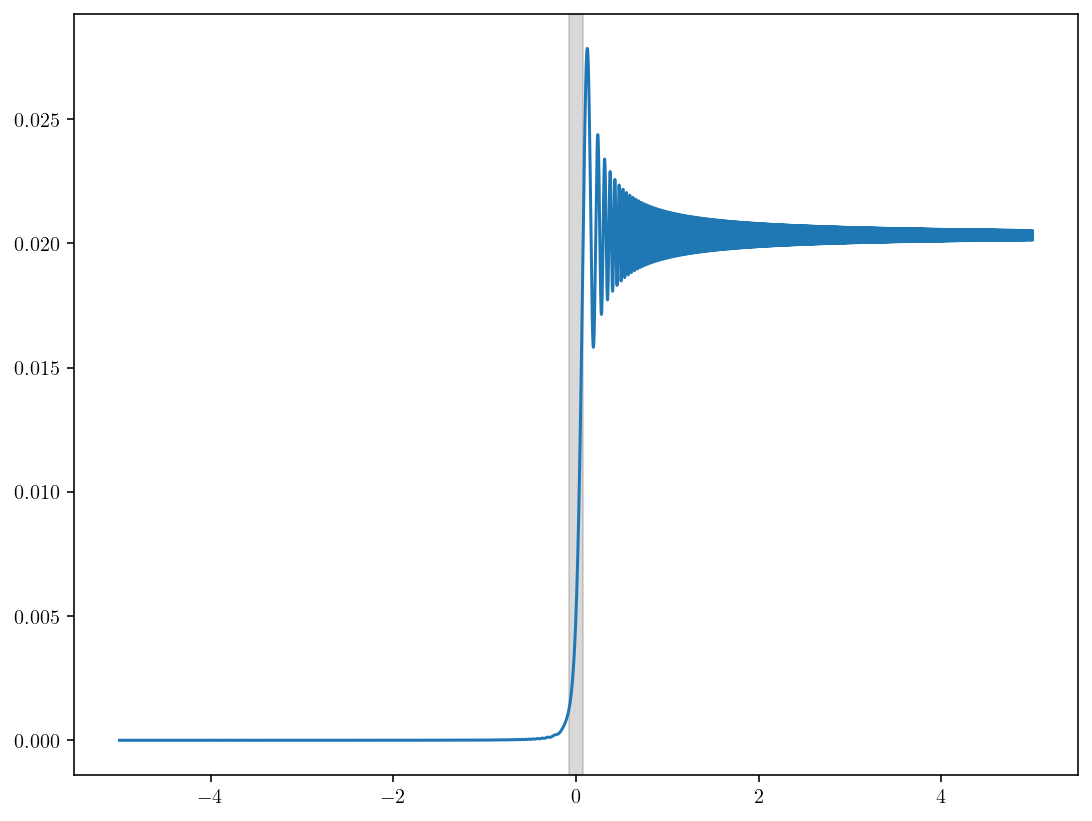

In [35]:
plt.plot(z_thr, p_LZ_1)
plt.axvspan( (z_res - R_lenght_tilde/2).item(), (z_res + R_lenght_tilde/2).item(), color='gray', alpha=0.3) 